In [1]:
suppressMessages(library(fable))
suppressMessages(library(forecast))
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(scales))
suppressMessages(library(feasts))
suppressMessages(library(magrittr))
suppressMessages(library(tsibble))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))
suppressMessages(library(tidyr))

In [9]:
df <- read.csv('monthly_housing_inventory.csv')
National <- df %>%
mutate(feet = median_square_feet * total_listing_count) %>%
group_by(month_date_yyyymm) %>%
summarise(
    total_listings = sum(total_listing_count, na.rm = TRUE),
    price = sum(median_listing_price,na.rm = TRUE),
    feet = sum(feet, na.rm=TRUE),
    total_active_listings = sum(active_listing_count,na.rm = TRUE), .groups='drop',
) %>%
mutate(wgt_median_square_feet = feet / total_listings, wgt_median_price = price / total_listings) %>%
mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m')) %>%

as_tsibble(index=month_date)

# Median Squarefoot

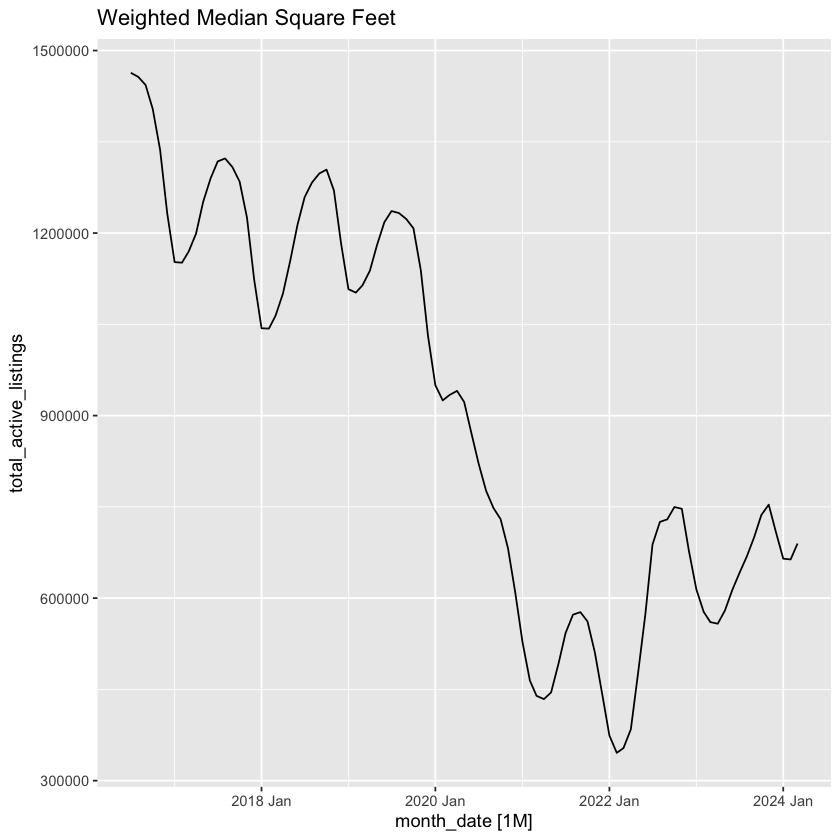

In [10]:
National |> autoplot(total_active_listings) +
  labs(title = "Weighted Median Square Feet")

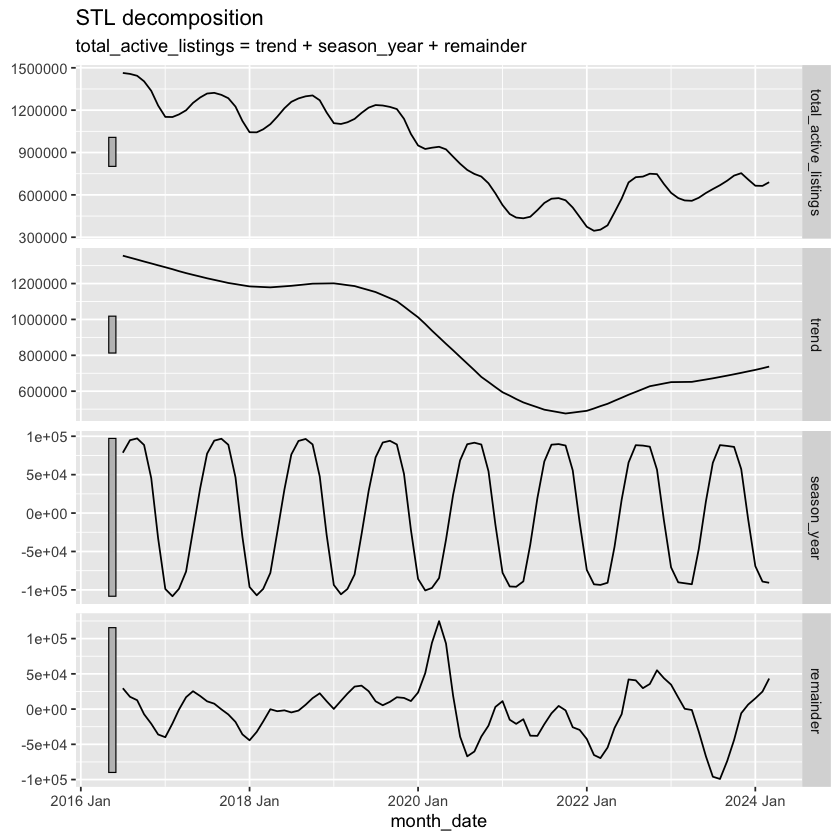

In [11]:
components <- National |> fill_gaps() |> model(
    stl = STL(total_active_listings ~ season(), robust = TRUE)
  ) |>
  components()
components |> autoplot()

# Outliers

In [12]:
outliers <- components |>filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers |> select(total_active_listings)

total_active_listings,month_date,.model
<dbl>,<mth>,<chr>


Plot variable not specified, automatically selected `.vars = total_active_listings`


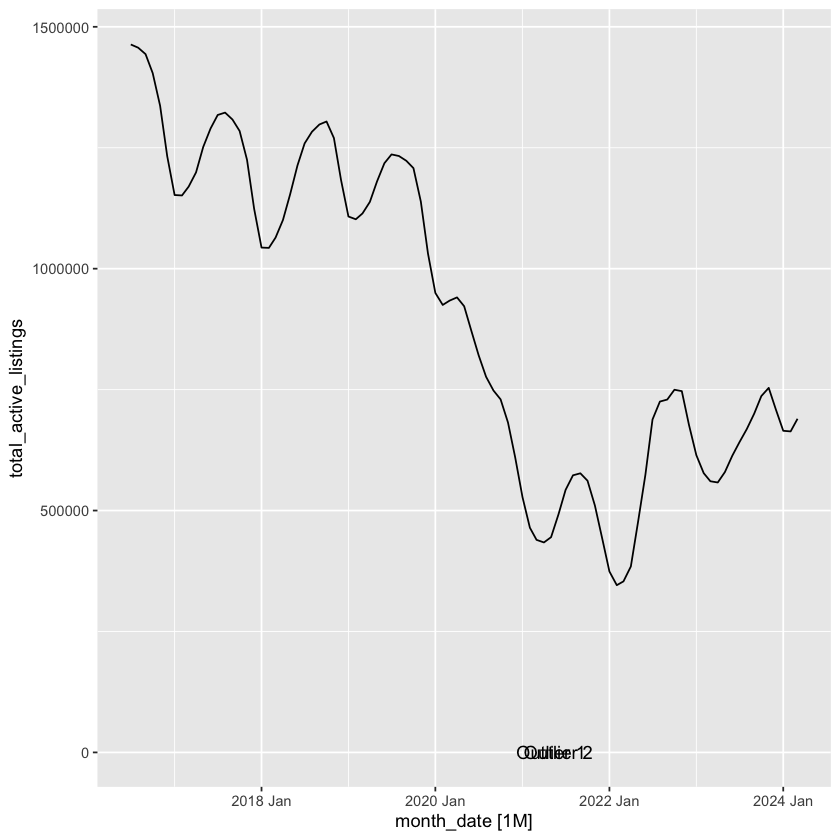

In [13]:
autoplot(National |> select(total_active_listings)) +
  annotate("text", x = yearmonth('2021 May'), y = 1880.081, label = 'Outlier 1') +
  annotate("text", x = yearmonth('2021 Jun'), y = 1883.397, label = 'Outlier 2')


# Removing outliers and missing Values

In [14]:
missing <- National |> select(total_active_listings) |>  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

Joining with `by = join_by(total_active_listings, month_date)`


In [15]:
total_active_listings <- National |> select(total_active_listings)
total_active_listings <- missing |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(total_active_listings)) |>
  # Estimate Trips for all periods
  interpolate(missing)

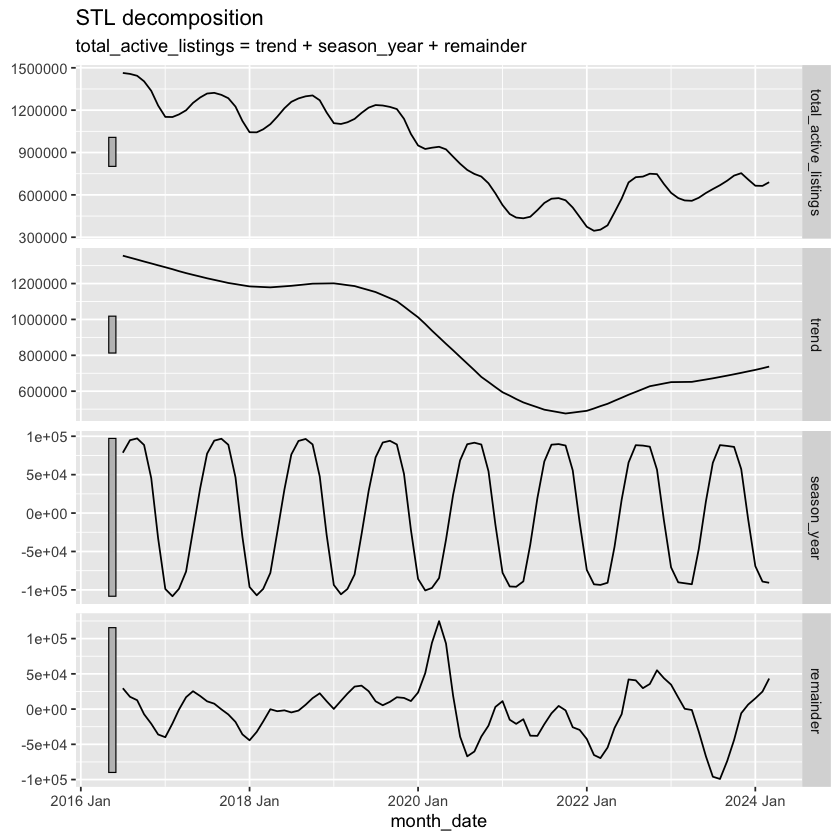

In [16]:
components <- total_active_listings |> model(
    stl = STL(total_active_listings ~ season(), robust = TRUE)
  ) |>
  components()
components |> autoplot()

In [17]:
ts <- ts(total_active_listings$total_active_listings,start=c(2016,6), frequency = 12)

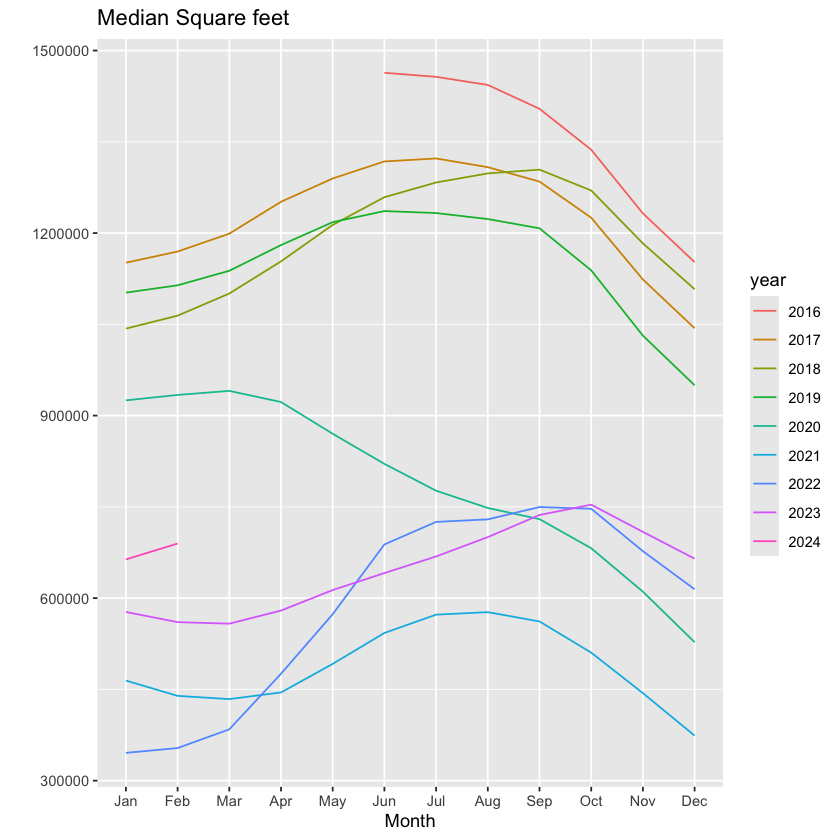

In [18]:
ts |> ggseasonplot() + labs(title = "Median Square feet")


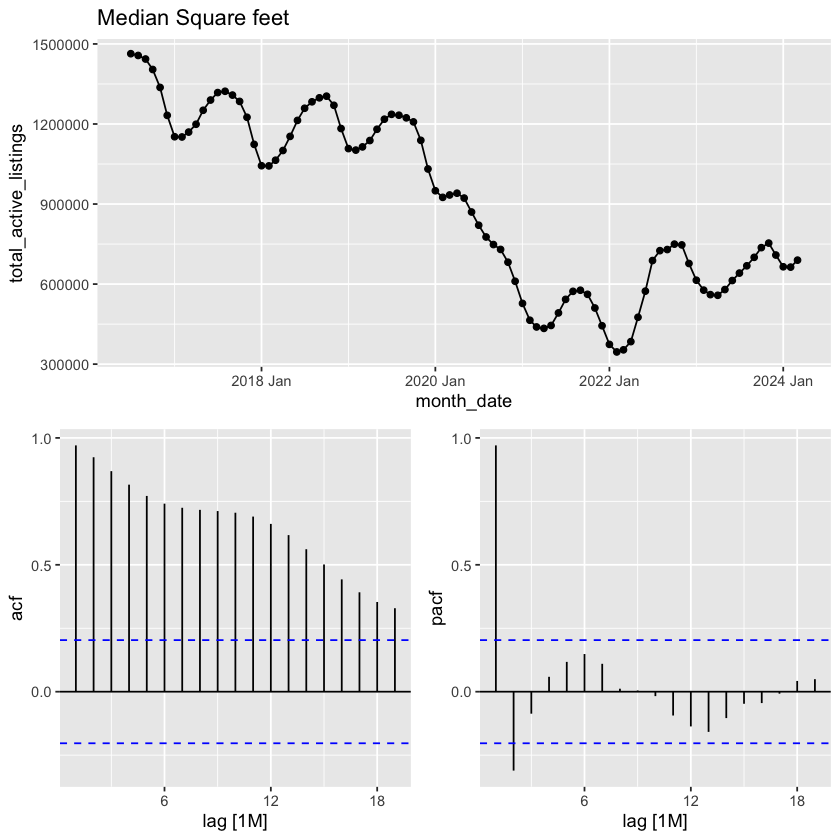

In [19]:
total_active_listings |> gg_tsdisplay(total_active_listings, plot_type = 'partial') + labs(title='Median Square feet')

# Description of the data

<br>Seaonal data with constant seasonality

Decreasing trend




In [20]:
missing_total_listings <- National |> select(total_listings) |>  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

Joining with `by = join_by(month_date)`


In [21]:
total_listings <- National |> select(total_listings)
total_listings <- missing_total_listings |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(total_listings)) |>
  # Estimate Trips for all periods
  interpolate(missing_total_listings)

# Modeling and Training

Here I want to use a regression model with total_listings as a predictor so I am merging the two data frames.

In [22]:
merged <- total_active_listings |>
inner_join(total_listings, by='month_date')

# Test Train Split

In [23]:
training <- merged %>% filter_index(. ~ '2022 Mar')
test <- merged %>% filter_index('2022 Apr' ~ .)

In [24]:
#training
merged |> head()

month_date,total_active_listings,total_listings
<mth>,<dbl>,<dbl>
2016 Jul,1463458,1873362
2016 Aug,1456819,1845212
2016 Sep,1443501,1809143
2016 Oct,1404257,1753435
2016 Nov,1337018,1664952
2016 Dec,1232380,1522590


In [27]:
models <- training |>
model(
    'Reg' = TSLM(total_active_listings ~ trend() + season() + total_listings),
)

In [28]:
models %>% report()

Series: total_active_listings 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-122050.6  -23235.4    -401.4   27731.6   94330.4 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -6.870e+05  1.062e+05  -6.469 2.79e-08 ***
trend()        -9.989e+02  7.288e+02  -1.371   0.1760    
season()year2  -7.064e+04  2.833e+04  -2.494   0.0157 *  
season()year3  -1.344e+05  2.913e+04  -4.615 2.40e-05 ***
season()year4  -1.934e+05  3.214e+04  -6.018 1.51e-07 ***
season()year5  -2.456e+05  3.427e+04  -7.166 2.02e-09 ***
season()year6  -2.792e+05  3.629e+04  -7.695 2.75e-10 ***
season()year7  -2.797e+05  3.580e+04  -7.813 1.76e-10 ***
season()year8  -2.663e+05  3.584e+04  -7.431 7.43e-10 ***
season()year9  -2.418e+05  3.528e+04  -6.854 6.54e-09 ***
season()year10 -2.194e+05  3.451e+04  -6.357 4.23e-08 ***
season()year11 -1.717e+05  3.216e+04  -5.340 1.82e-06 ***
season()year12 -7.428e+04  2.898e+04  -2.563   0.0131 *  
total_listings 

In [30]:
models |> accuracy() |> select(.model,RMSE, ACF1, MAPE)

.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
Reg,43518.38,0.7806371,4.306673


# I Have manually Inserted the scores from other Time series models(I have computed them on a different notebook)

.model	RMSE	ACF1	MAPE
<chr>	<dbl>	<dbl>	<dbl>
    
ETS	    21370.57	0.60050102	1.962593
    
ARIMA	12943.74	0.04302159	1.198224
    
SNAIVE	241139.17	0.97767859	28.571646
    
RW	    44213.47	0.77987864	4.334702


# Residual Analysis

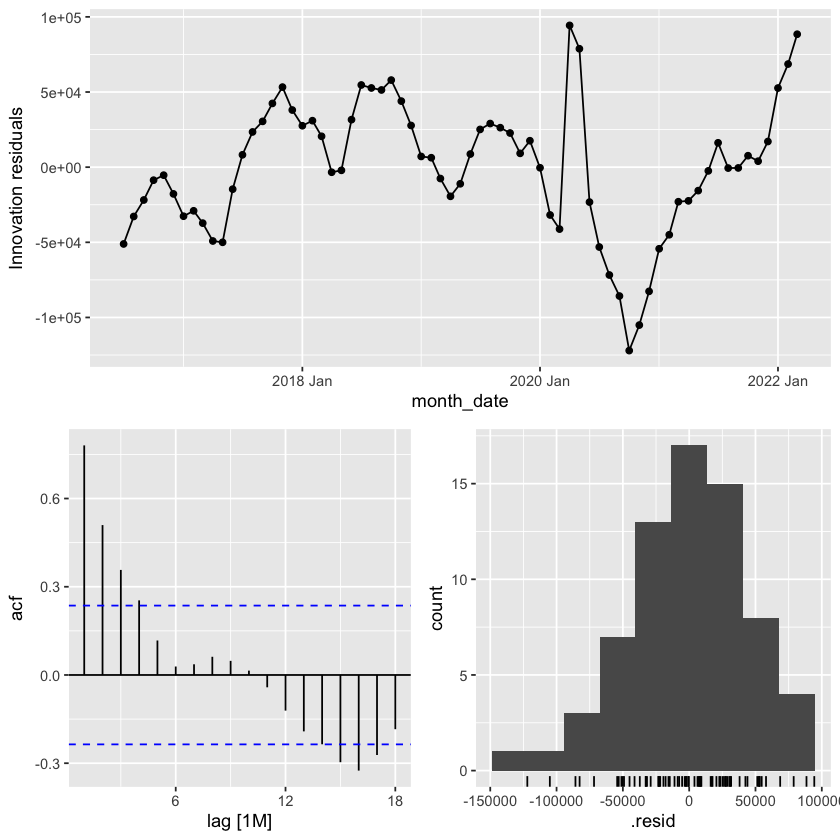

In [31]:
models %>% select(Reg) %>% gg_tsresiduals()

# Test Performance

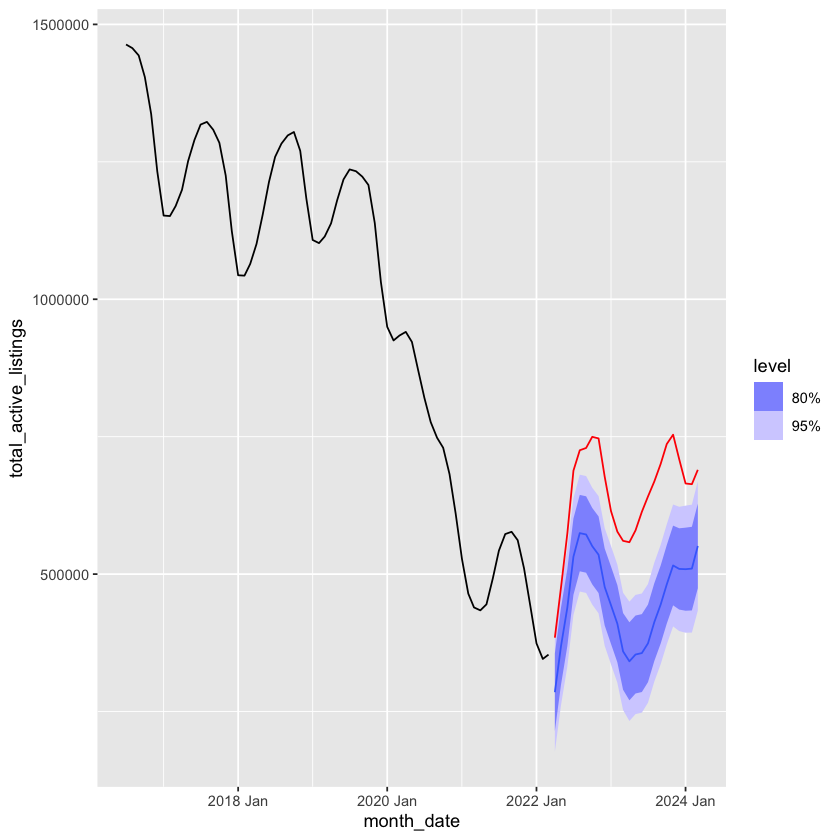

In [32]:
forecast_Reg <- models %>% select(Reg) %>% forecast(test)

forecast_Reg %>% autoplot(training) +
autolayer(test, total_active_listings, col='red')

In [33]:
fabletools::accuracy(forecast_Reg, total_active_listings) |> select(.model,RMSE, ACF1, MAPE)

.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
Reg,196696.7,0.8059492,29.63505


 # Time based models
 
 .model	RMSE	ACF1	MAPE
<chr>	<dbl>	<dbl>	<dbl>
    
ETS	298335.5	0.7549012	42.05517

ARIMA	414798.1	0.7892377	57.9405

SNAIVE	195644.3	0.7090571	27.09732

RW	524058.9	0.7676453	74.80608


# We can see that Regression model performed second best comparing to SNAIVE on Test Set

Plot variable not specified, automatically selected `.vars = total_active_listings`


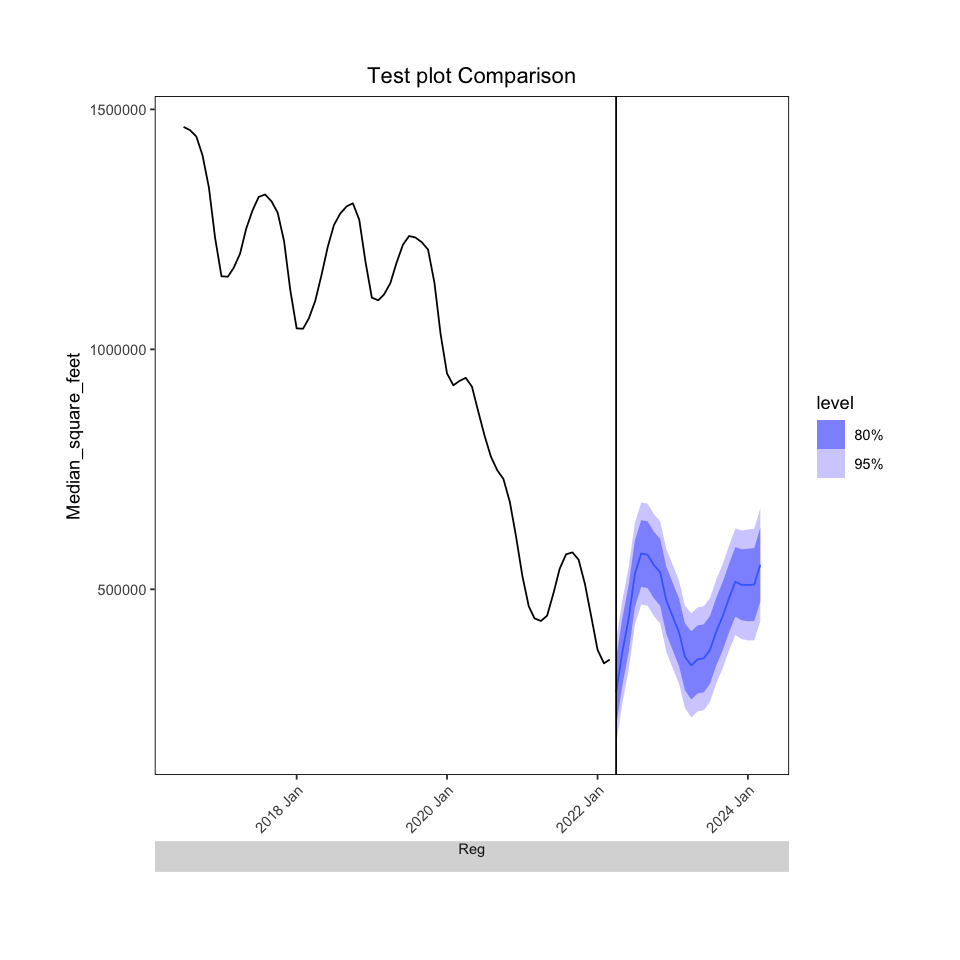

In [33]:
options(repr.plot.width=8, repr.plot.height=8)
models |> forecast(test) |> autoplot() +
facet_wrap(. ~ .model,strip.position = "bottom", scales = "free_x") +
autolayer(training) +
labs(title='Test plot Comparison', y='Median_square_feet', x='') +
geom_vline(xintercept = as.Date('2022-04-01'))+
theme(strip.text.x = element_text(margin = margin(b = 10)),
        strip.placement = "outside")+theme(panel.spacing = unit(2, "lines")) +
theme(plot.title = element_text(hjust = 0.5)) +  # Center the plot title
  theme(plot.margin = margin(40, 40, 40, 40)) +  # Adjust the plot margins
  theme(plot.background = element_rect(fill = "white")) +  # Set plot background color to white
  theme(panel.background = element_rect(fill = "white")) +  # Set panel background color to white
  theme(panel.border = element_rect(color = "black", fill = NA)) +  # Set panel border color to black
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

# Forecasts

# Total Listings Forcasts

Need to forecast the total listing counts so those forecasts can be used as inputs to the Regressor for Active Listings

In [35]:
forecasts_Total_Listings <- total_listings |> 
model(
    'ETS' = ETS(total_listings),
) |> forecast(h=12) |> 
as.data.frame() |>
select(month_date, .mean) |>
rename(total_listings = .mean) |>
as_tsibble(index=month_date)

# Forecasts for Active Listings

In [36]:
forecasts <- merged |> 
model(
    'Reg' = TSLM(total_active_listings ~ trend() + season() + total_listings),
) |> forecast(forecasts_Total_Listings)

Plot variable not specified, automatically selected `.vars = total_active_listings`


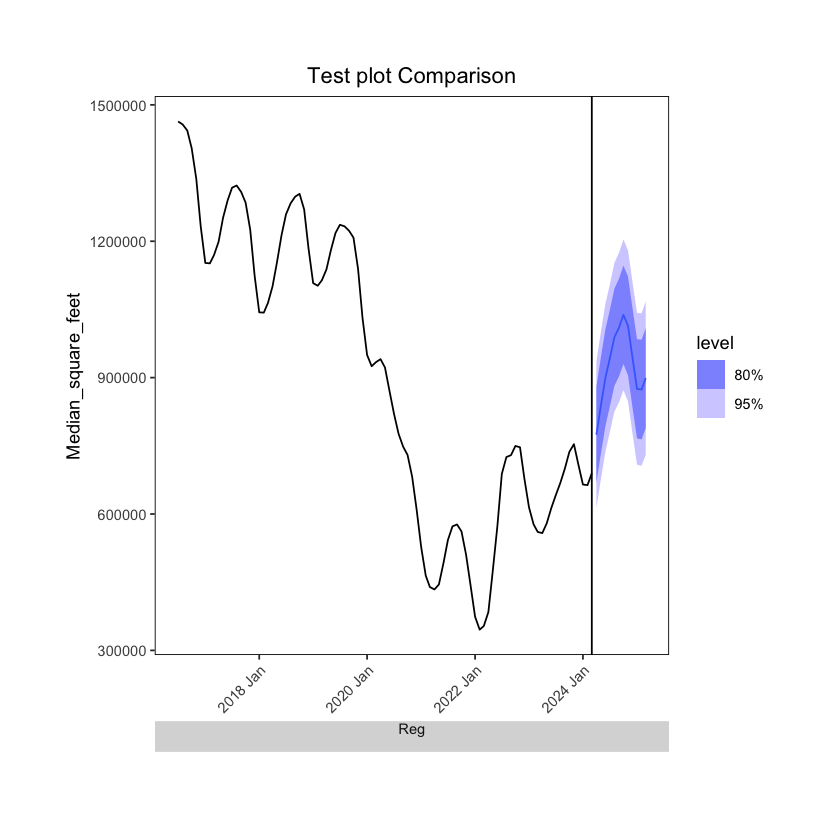

In [38]:
forecasts |> autoplot() +
facet_wrap(. ~ .model,strip.position = "bottom", scales = "free_x") +
autolayer(total_active_listings) +
labs(title='Test plot Comparison', y='Median_square_feet', x='') +
geom_vline(xintercept = as.Date('2024-03-01'))+
theme(strip.text.x = element_text(margin = margin(b = 10)),
        strip.placement = "outside")+theme(panel.spacing = unit(2, "lines")) +
theme(plot.title = element_text(hjust = 0.5)) +  
  theme(plot.margin = margin(40, 40, 40, 40)) +  
  theme(plot.background = element_rect(fill = "white")) +  
  theme(panel.background = element_rect(fill = "white")) +  
  theme(panel.border = element_rect(color = "black", fill = NA)) +  
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [39]:
forecasts #|> as.data.frame() |> select(month_date,.mean)

.model,month_date,total_active_listings,.mean,total_listings
<chr>,<mth>,<dist>,<dbl>,<dbl>
Reg,2024 Apr,"N(774480, 6.8e+09)",774480.4,1167017
Reg,2024 May,"N(837706, 6.8e+09)",837705.9,1251145
Reg,2024 Jun,"N(9e+05, 6.9e+09)",899543.8,1315892
Reg,2024 Jul,"N(942551, 6.9e+09)",942551.1,1340483
Reg,2024 Aug,"N(988881, 7e+09)",988881.1,1365074
Reg,2024 Sep,"N(1e+06, 7e+09)",1010063.0,1361110
Reg,2024 Oct,"N(1e+06, 7.1e+09)",1038179.6,1359920
Reg,2024 Nov,"N(1e+06, 7.2e+09)",1013815.9,1305700
Reg,2024 Dec,"N(944636, 7.2e+09)",944635.9,1184483
